In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import funs_project as fp

# Optimisation

In [2]:
ACTORNAME = "Deventer"

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

## Reading

In [4]:
cases = fp.the_cases(ACTORNAME)

In [5]:
policies = fp.crude_policy_selection(ACTORNAME, 6)

In [6]:
policies = policies.sort_values(by="scenario")
policies

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,scenario
1,1,1,1,0,0,0,0,0,9,0,0.000000e+00,0.000000,0.000000,1
2,1,1,1,0,0,0,4,10,10,5,0.000000e+00,0.000000,0.000000,2
4,1,1,1,0,0,0,2,5,9,9,2.745452e+07,0.004504,1735.638064,3
3,1,1,1,0,0,0,0,5,1,1,2.745452e+07,0.030030,0.000000,3
5,1,1,1,0,0,0,1,8,10,9,3.493751e+08,0.086220,9607.967707,4
8,1,1,1,0,0,0,0,8,1,2,3.493751e+08,0.239501,0.000000,4
7,1,1,1,0,0,0,2,8,8,4,3.493751e+08,0.035925,15950.727638,4
6,1,1,1,0,0,0,3,4,2,2,3.493751e+08,0.028740,19816.433396,4
12,1,1,1,0,0,0,3,0,0,0,5.151538e+08,0.038097,27995.501402,5
9,1,1,1,0,0,0,2,0,0,0,5.151538e+08,0.047621,22534.257758,5


In [7]:
policies.iloc[:, 0:10]

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2
1,1,1,1,0,0,0,0,0,9,0
2,1,1,1,0,0,0,4,10,10,5
4,1,1,1,0,0,0,2,5,9,9
3,1,1,1,0,0,0,0,5,1,1
5,1,1,1,0,0,0,1,8,10,9
8,1,1,1,0,0,0,0,8,1,2
7,1,1,1,0,0,0,2,8,8,4
6,1,1,1,0,0,0,3,4,2,2
12,1,1,1,0,0,0,3,0,0,0
9,1,1,1,0,0,0,2,0,0,0


Below we plot per scenario 

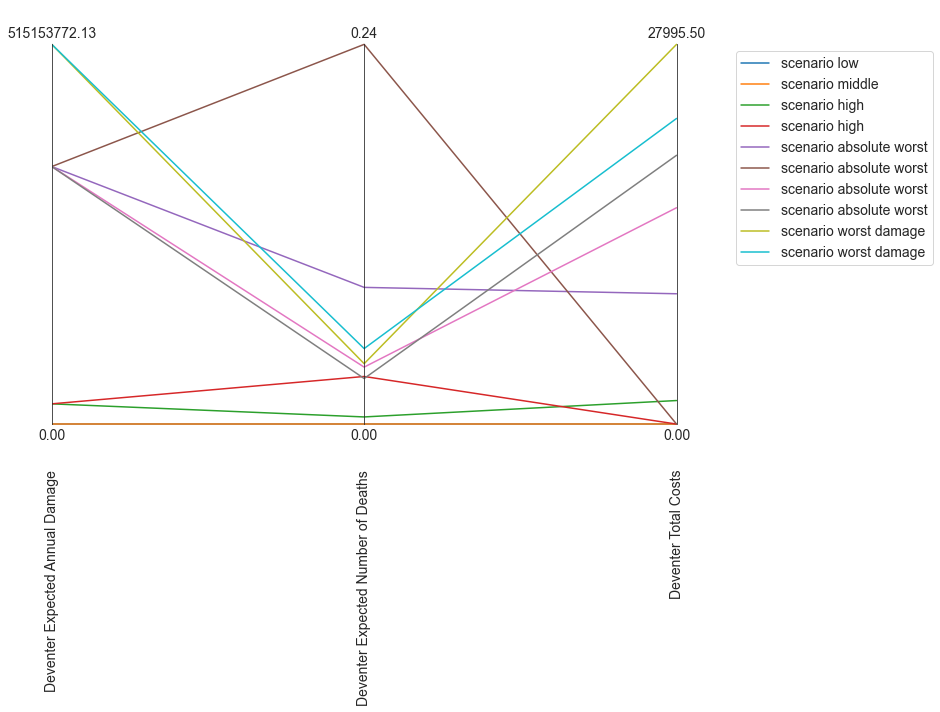

In [44]:
colors = iter(sns.color_palette())
limits = parcoords.get_limits(policies.iloc[:, 10:13])

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for index, row in policies.iterrows():
    color = next(colors)
    paraxes.plot(row, label=f'scenario {cases[row.scenario]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.tight_layout()
plt.show()


# Reevaluate under deep uncertainty

## Reading

In [9]:
n_scenarios = 1000

In [10]:
du_experiments, du_outcomes = load_results("simulation/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

### Keep only the DU experiments and outcomes that are in POLICIES

In [11]:
du_outcomes_df = pd.DataFrame.from_dict(du_outcomes)
merged_du = pd.concat([du_experiments, du_outcomes_df], axis=1)
merged_du

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,A.0_ID flood wave shape,...,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,scenario,policy,model,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,51.0,...,1.0,2.0,0.0,0.0,1000,scenario best option 0,dikesnet,7.550464e+07,0.030320,3044.580453
1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,108.0,...,1.0,2.0,0.0,0.0,1001,scenario best option 0,dikesnet,2.968128e+08,0.072625,8258.317156
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1002,scenario best option 0,dikesnet,0.000000e+00,0.000000,0.000000
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,101.0,...,1.0,2.0,0.0,0.0,1003,scenario best option 0,dikesnet,1.216972e+07,0.005227,481.619923
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,36.0,...,1.0,2.0,0.0,0.0,1004,scenario best option 0,dikesnet,6.661154e+06,0.003266,303.355467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,45.0,...,3.0,0.0,0.0,0.0,1995,scenario worst damage option 3,dikesnet,5.226403e+07,0.005785,3563.034850
12996,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,40.0,...,3.0,0.0,0.0,0.0,1996,scenario worst damage option 3,dikesnet,1.197295e+07,0.001210,727.284186
12997,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,126.0,...,3.0,0.0,0.0,0.0,1997,scenario worst damage option 3,dikesnet,4.541983e+07,0.006310,3821.274063
12998,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,123.0,...,3.0,0.0,0.0,0.0,1998,scenario worst damage option 3,dikesnet,0.000000e+00,0.000000,0.000000


In [12]:
#now compare the policies in merged_du to the policies in 'policies' 
policies_policy_df = policies.iloc[:, 0:10]
DU_policy_selected_df = pd.merge(policies_policy_df, merged_du, how = "inner")
DU_policy_selected_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,...,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
0,1,1,1,0,0,0,0,0,9,0,...,0.145196,4.5,4.5,2.5,1000,scenario low option 0,dikesnet,3.893922e+07,0.043001,0.000000
1,1,1,1,0,0,0,0,0,9,0,...,0.048297,1.5,2.5,1.5,1001,scenario low option 0,dikesnet,1.174954e+08,0.085181,0.000000
2,1,1,1,0,0,0,0,0,9,0,...,0.799841,3.5,2.5,1.5,1002,scenario low option 0,dikesnet,0.000000e+00,0.000000,0.000000
3,1,1,1,0,0,0,0,0,9,0,...,0.644478,3.5,3.5,4.5,1003,scenario low option 0,dikesnet,2.147294e+06,0.002632,0.000000
4,1,1,1,0,0,0,0,0,9,0,...,0.624614,3.5,4.5,4.5,1004,scenario low option 0,dikesnet,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,1,0,0,0,2,0,0,0,...,0.199370,2.5,2.5,3.5,1995,scenario worst damage option 0,dikesnet,5.226403e+07,0.007231,2867.973128
9996,1,1,1,0,0,0,2,0,0,0,...,0.408387,3.5,2.5,1.5,1996,scenario worst damage option 0,dikesnet,1.197295e+07,0.001512,585.408672
9997,1,1,1,0,0,0,2,0,0,0,...,0.168875,3.5,3.5,4.5,1997,scenario worst damage option 0,dikesnet,4.541983e+07,0.007888,3075.836130
9998,1,1,1,0,0,0,2,0,0,0,...,0.666962,3.5,2.5,1.5,1998,scenario worst damage option 0,dikesnet,0.000000e+00,0.000000,0.000000


#### rewrite du_experiments and du_outcomes with the filtered version

In [13]:
du_outcomes_policy_df = DU_policy_selected_df[DU_policy_selected_df.columns[-3:]].copy()
du_experiments = DU_policy_selected_df[DU_policy_selected_df.columns[0:50]].copy()
du_outcomes = du_outcomes_policy_df.to_dict('series')

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

In [14]:
outcomekeys = list(du_outcomes.keys())
outcomekeys

['Deventer Expected Annual Damage',
 'Deventer Expected Number of Deaths',
 'Deventer Total Costs']

In [15]:
DAMAGE = outcomekeys[0]
DEATHS = outcomekeys[1]
COSTS = outcomekeys[2]

Regret calculation based on assignments

In [16]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    best = temp_results.min()
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

In [17]:
temp_experiments.policy.values

['scenario low option 0', 'scenario middle option 0', 'scenario high option 1', 'scenario high option 0', 'scenario absolute worst option 0', 'scenario absolute worst option 3', 'scenario absolute worst option 2', 'scenario absolute worst option 1', 'scenario worst damage option 3', 'scenario worst damage option 0']
Categories (13, object): ['scenario absolute worst option 0', 'scenario absolute worst option 1', 'scenario absolute worst option 2', 'scenario absolute worst option 3', ..., 'scenario worst damage option 0', 'scenario worst damage option 1', 'scenario worst damage option 2', 'scenario worst damage option 3']

In [18]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max().dropna()

In [19]:
maxregret

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
policy,,,
scenario absolute worst option 0,1.975364e+08,0.158755,29976.698139
scenario absolute worst option 1,1.960830e+08,0.022271,61826.939912
scenario absolute worst option 2,1.975364e+08,0.028105,49766.002770
scenario absolute worst option 3,1.975364e+08,0.581652,0.000000
scenario high option 0,1.969750e+08,0.581652,0.000000
scenario high option 1,1.974474e+08,0.028085,49766.002770
scenario low option 0,1.486332e+08,0.581184,0.000000
scenario middle option 0,1.975364e+08,0.022484,72131.429897
scenario worst damage option 0,0.000000e+00,0.019781,49698.225742


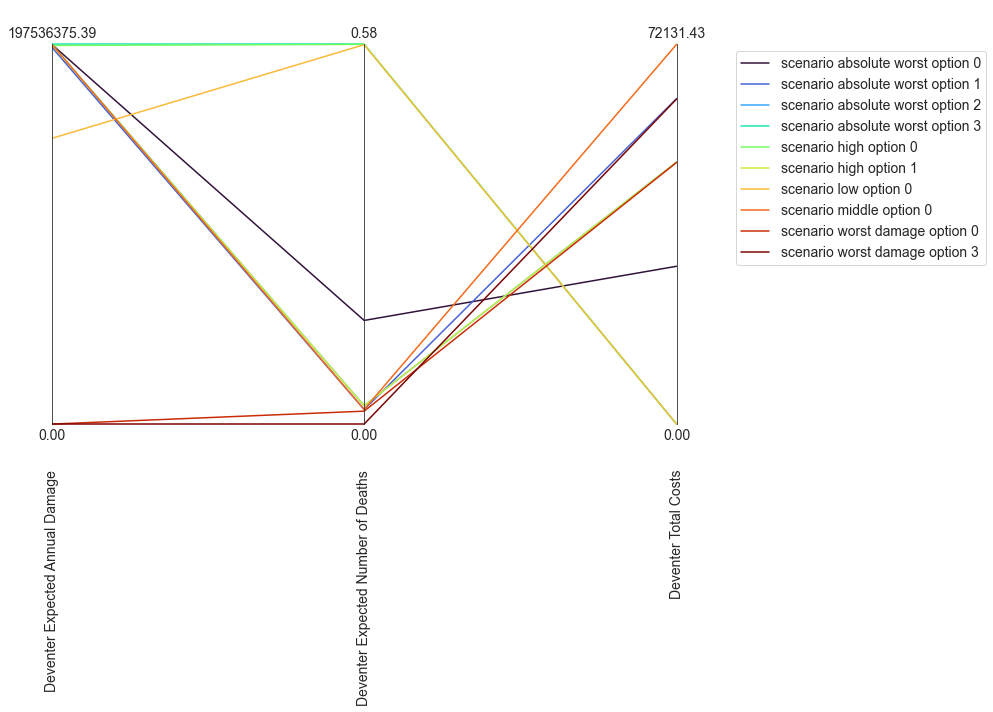

In [48]:
from matplotlib import cm

limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)


cmap = cm.get_cmap('turbo', maxregret.shape[0])
i=0
for index, row in maxregret.iterrows():
    paraxes.plot(row, color=cmap.colors[i], label=index)
    i+=1
    
paraxes.legend()
plt.savefig("../../report/figures/results/regret_figure"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

For the city of Deventer, treshold values for Damage, Deaths and Costs are listed below. These values are based on ...
- Damage: 3.5e8
- Deaths: 0.05
- Costs: 16000

## These are a guestimate based on the table above, a better number is still more important

In [21]:
satisfycing_df = policies.copy()
satisfycing_df.drop_duplicates(inplace=True)
#satisfycing_df

In [22]:
belowtresh_df = satisfycing_df.loc[(satisfycing_df['Deventer Expected Annual Damage'] < fp.thresholds_deventer['Deventer Expected Annual Damage']) & \
                    (satisfycing_df['Deventer Expected Number of Deaths'] < fp.thresholds_deventer['Deventer Expected Number of Deaths']) & \
                    (satisfycing_df['Deventer Total Costs'] < fp.thresholds_deventer['Deventer Total Costs']),:].copy()
belowtresh_df.sort_index(inplace=True, ascending = False)
belowtresh_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,scenario
2,1,1,1,0,0,0,4,10,10,5,0.0,0.0,0.0,2
1,1,1,1,0,0,0,0,0,9,0,0.0,0.0,0.0,1


In [23]:
limits_df = belowtresh_df.iloc[:, -4:-1]
colors = iter(sns.color_palette())
limits = parcoords.get_limits(limits_df)

In [24]:

overall_scores = {}
for policy in du_experiments.policy.unique():
    logical = du_experiments.policy == policy
    scores = {}
    for k, v in du_outcomes.items():
        try:
            n = np.sum(v[logical]<=fp.thresholds_deventer[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

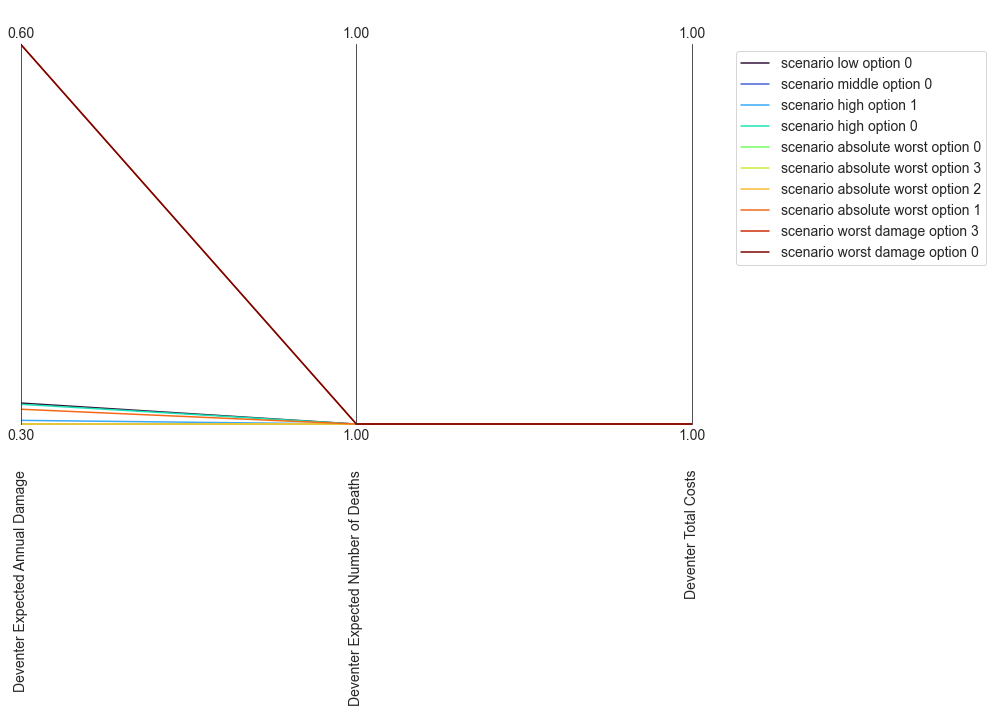

In [49]:
from matplotlib import cm

limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)


cmap = cm.get_cmap('turbo', overall_scores.shape[0])
i=0
for index, row in overall_scores.iterrows():
    paraxes.plot(row, color=cmap.colors[i], label=index)
    i+=1
    
paraxes.legend()
plt.savefig("../../report/figures/results/domain_criterion"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

In [26]:
overall_scores

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
scenario low option 0,0.313,1.0,1.0
scenario middle option 0,0.296,1.0,1.0
scenario high option 1,0.299,1.0,1.0
scenario high option 0,0.312,1.0,1.0
scenario absolute worst option 0,0.296,1.0,1.0
scenario absolute worst option 3,0.296,1.0,1.0
scenario absolute worst option 2,0.296,1.0,1.0
scenario absolute worst option 1,0.308,1.0,1.0
scenario worst damage option 3,0.603,1.0,1.0
scenario worst damage option 0,0.603,1.0,1.0


## Scoring policies

### Normalise the regret and take the average to score the policies


In [27]:
from sklearn import preprocessing

In [28]:
#Normalize the regret results
regret_scores = maxregret.copy()
regret_average = regret_scores.apply(lambda x: x/x.max(), axis=0)


In [29]:
#Get the average for each policy
regret_average['average regret'] = regret_average.mean(numeric_only=True, axis=1)
regret_average.sort_values(by='average regret', ascending = False, inplace = True) #Lower = better
regret_average

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
policy,,,,
scenario middle option 0,1.000000,0.038655,1.000000,0.679552
scenario absolute worst option 3,1.000000,1.000000,0.000000,0.666667
scenario high option 0,0.997158,1.000000,0.000000,0.665719
scenario absolute worst option 1,0.992642,0.038290,0.857143,0.629358
scenario low option 0,0.752435,0.999197,0.000000,0.583877
scenario absolute worst option 2,1.000000,0.048319,0.689935,0.579418
scenario high option 1,0.999549,0.048286,0.689935,0.579257
scenario absolute worst option 0,1.000000,0.272938,0.415584,0.562841
scenario worst damage option 3,0.000000,0.000000,0.855976,0.285325


###  Use the satisficing / domain criterion and take their average to score the policies


In [30]:
#Get the average for each policy
satisficing_average = overall_scores.copy()
satisficing_average['average satisficing'] = satisficing_average.mean(numeric_only=True, axis=1)
satisficing_average.sort_values(by='average satisficing', ascending = True, inplace = True) #higher = better
satisficing_average

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing
scenario middle option 0,0.296,1.0,1.0,0.765333
scenario absolute worst option 0,0.296,1.0,1.0,0.765333
scenario absolute worst option 3,0.296,1.0,1.0,0.765333
scenario absolute worst option 2,0.296,1.0,1.0,0.765333
scenario high option 1,0.299,1.0,1.0,0.766333
scenario absolute worst option 1,0.308,1.0,1.0,0.769333
scenario high option 0,0.312,1.0,1.0,0.770667
scenario low option 0,0.313,1.0,1.0,0.771000
scenario worst damage option 3,0.603,1.0,1.0,0.867667
scenario worst damage option 0,0.603,1.0,1.0,0.867667


### Add them together  

In [31]:
merged_df = pd.concat([satisficing_average, regret_average], join="inner", axis = 1)


In [32]:
merged_df.sort_values(by='average satisficing', inplace = True, ascending = True)
merged_df.sort_values(by='average regret', inplace = True, ascending = False)
merged_df

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
scenario middle option 0,0.296,1.0,1.0,0.765333,1.000000,0.038655,1.000000,0.679552
scenario absolute worst option 3,0.296,1.0,1.0,0.765333,1.000000,1.000000,0.000000,0.666667
scenario high option 0,0.312,1.0,1.0,0.770667,0.997158,1.000000,0.000000,0.665719
scenario absolute worst option 1,0.308,1.0,1.0,0.769333,0.992642,0.038290,0.857143,0.629358
scenario low option 0,0.313,1.0,1.0,0.771000,0.752435,0.999197,0.000000,0.583877
scenario absolute worst option 2,0.296,1.0,1.0,0.765333,1.000000,0.048319,0.689935,0.579418
scenario high option 1,0.299,1.0,1.0,0.766333,0.999549,0.048286,0.689935,0.579257
scenario absolute worst option 0,0.296,1.0,1.0,0.765333,1.000000,0.272938,0.415584,0.562841
scenario worst damage option 3,0.603,1.0,1.0,0.867667,0.000000,0.000000,0.855976,0.285325
scenario worst damage option 0,0.603,1.0,1.0,0.867667,0.000000,0.034009,0.688995,0.241001


In [33]:
#take te most robust policies and put them into a df.
robust_policies = merged_df.tail(5)
robust_policies

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
scenario absolute worst option 2,0.296,1.0,1.0,0.765333,1.000000,0.048319,0.689935,0.579418
scenario high option 1,0.299,1.0,1.0,0.766333,0.999549,0.048286,0.689935,0.579257
scenario absolute worst option 0,0.296,1.0,1.0,0.765333,1.000000,0.272938,0.415584,0.562841
scenario worst damage option 3,0.603,1.0,1.0,0.867667,0.000000,0.000000,0.855976,0.285325
scenario worst damage option 0,0.603,1.0,1.0,0.867667,0.000000,0.034009,0.688995,0.241001


In [34]:
#now to return to an original list of policies with this
policy_names = robust_policies.index.values.tolist()

In [35]:
policy_names

['scenario absolute worst option 2',
 'scenario high option 1',
 'scenario absolute worst option 0',
 'scenario worst damage option 3',
 'scenario worst damage option 0']

In [36]:
temp_results = DU_policy_selected_df[DU_policy_selected_df['policy'].isin(policy_names)]

In [37]:
lever_names = policies_policy_df.columns.values.tolist()
lever_names

['3_RfR 0',
 '3_RfR 1',
 '3_RfR 2',
 '4_RfR 0',
 '4_RfR 1',
 '4_RfR 2',
 'EWS_DaysToThreat',
 'A.4_DikeIncrease 0',
 'A.4_DikeIncrease 1',
 'A.4_DikeIncrease 2']

In [38]:
robust_policies_results = temp_results[lever_names].drop_duplicates()

In [39]:
robust_policies_results

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2
2000,1,1,1,0,0,0,2,5,9,9
4000,1,1,1,0,0,0,1,8,10,9
6000,1,1,1,0,0,0,2,8,8,4
8000,1,1,1,0,0,0,3,0,0,0
9000,1,1,1,0,0,0,2,0,0,0


In [40]:
robust_policies_results.to_csv('simulation/selected/selected_policies_' + ACTORNAME + '.csv')